In [2]:
#loading packages
library(plyr); library(dplyr)
library(ggplot2)
library(HTSSIP)
library(phyloseq)
library(data.table)
library(stringr)
library(tidyr)
library(RColorBrewer)
library(cowplot)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

------------------------------------------------------------------------------
data.table + dplyr code now lives in dtplyr.
Please library(dtplyr)!
------------------------------------------------------------------------------

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [184]:
#importing metadata
sample.md = read.table("data/Metadata_fungi.txt", 
                comment.char = "",
                header = TRUE,
                colClasses = c("Density" = "numeric"))
rownames(sample.md) = as.character(sample.md[, 1])

sample.md = sample_data(sample.md)

In [185]:
#renaming Density column to Buoyant Density"
setnames(sample.md, "Density", "Buoyant_density")

In [186]:
#importing biom data
physeq = import_biom("data/SIP_Bulk_otu_table_wtax.biom") 

In [187]:
#adding sample data to physeq object
sample_data(physeq) = sample.md
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1905 taxa and 181 samples ]
sample_data() Sample Data:       [ 181 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 1905 taxa by 7 taxonomic ranks ]

In [188]:
physeq %>% sample_data %>% head

,SampleID,Primers,i2,i1,Day,Buoyant_density,Treatment,Mock_Comm,RNA_DNA
succ.12C.D14,succ.12C.D14,81,gtctatga,atcgtacg,14,NA,12CCPS,bulk,DNA
succ.13C.D30,succ.13C.D30,86,gtctatga,cgtgagtg,30,NA,13CCPS,bulk,DNA
succ.12C.D7,succ.12C.D7,80,gtctgcta,gacaccgt,7,NA,12CCPS,bulk,DNA
succ.13C.D3,succ.13C.D3,83,gtctatga,tagcgagt,3,NA,13CCPS,bulk,DNA
succ.13C.D14,succ.13C.D14,85,gtctatga,tcatcgag,14,NA,13CCPS,bulk,DNA
succ.12C.D30,succ.12C.D30,82,gtctatga,actatctg,30,NA,12CCPS,bulk,DNA


In [189]:
#pruning physeq object to heavy fractions only
dna.density.min = 1.7125

md = sample_data(physeq)
criterion = md$Buoyant_density >= with(md, dna.density.min)

physeq.heavy = prune_samples(criterion, physeq)

In [190]:
physeq.heavy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1905 taxa and 76 samples ]
sample_data() Sample Data:       [ 76 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 1905 taxa by 7 taxonomic ranks ]

In [191]:
#Checking for correct format in physeq object
physeq.heavy = physeq_format(physeq.heavy)

In [192]:
physeq.heavy %>% sample_data %>% .[1:4,1:9]


,SampleID,Primers,i2,i1,Day,Buoyant_density,Treatment,Mock_Comm,RNA_DNA
D713.15,D713.15,135,ggatatct,gatctacg,7,1.720939,13CCPS,N,DNA
D3012.7,D3012.7,67,tagcgagt,actacgac,30,1.752629,12CCPS,N,DNA
D1412.3,D1412.3,1,atcgtacg,cgagagtt,14,1.755907,12CCPS,N,DNA
D1413.10,D1413.10,31,ggatatct,actcactg,14,1.729681,13CCPS,N,DNA


In [193]:
#creating expression to subset physeq objects 
ex = "(Treatment=='12CCPS' & Day=='${Day}') | (Treatment=='${Treatment}' & Day == '${Day}')"

In [194]:
#creating set of parameters for use in subsetting physeq object
params = get_treatment_params(physeq.heavy, c('Treatment', 'Day'), "Treatment != '12CCPS'")
params

Treatment,Day
13CCPS,7
13CCPS,14
13CCPS,30
13CCPS,3


In [195]:
#subsetting physeq object based on above parameters inserted into above expression 
physeq.heavy.filt = phyloseq_subset(physeq.heavy, params, ex)
physeq.heavy.filt

$`(Treatment=='12CCPS' & Day=='7') | (Treatment=='13CCPS' & Day == '7')`
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1905 taxa and 19 samples ]
sample_data() Sample Data:       [ 19 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 1905 taxa by 7 taxonomic ranks ]

$`(Treatment=='12CCPS' & Day=='14') | (Treatment=='13CCPS' & Day == '14')`
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1905 taxa and 20 samples ]
sample_data() Sample Data:       [ 20 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 1905 taxa by 7 taxonomic ranks ]

$`(Treatment=='12CCPS' & Day=='30') | (Treatment=='13CCPS' & Day == '30')`
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1905 taxa and 18 samples ]
sample_data() Sample Data:       [ 18 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 1905 taxa by 7 taxonomic ranks ]

$`(Treatment=='12CCPS' & Day=='3') | (Treatment=='13CCPS'

In [196]:
# adjusted P-value cutoff 
padj_cutoff = 0.1
# number of cores for parallel processing (increase depending on your computational hardware)
ncores = 5

In [197]:
windows = data.frame(density_min=c(1.70, 1.72, 1.74), 
                     density_max=c(1.73, 1.75, 1.77))
windows

density_min,density_max
1.70,1.73
1.72,1.75
1.74,1.77


In [198]:
thresh = seq(0.05, 0.95, 0.05)

thresh

[1] 0.05 0.10 0.15 0.20 0.25 0.30 0.35 0.40 0.45 0.50 0.55 0.60 0.65 0.70 0.75
[16] 0.80 0.85 0.90 0.95

In [199]:
##Running with multiple windows
doParallel::registerDoParallel(ncores)

df_l2fc = plyr::ldply(physeq.heavy.filt, 
                      HRSIP, 
                      density_windows = windows,
                      design = ~Treatment, 
                      padj_cutoff = padj_cutoff,
                      sparsity_threshold = thresh, # just using 3 thresholds to reduce run time
                      .parallel = TRUE)
df_l2fc %>% head(n=3)

.id,OTU,log2FoldChange,p,padj,Rank1,Rank2,Rank3,Rank4,Rank5,Rank6,Rank7,density_min,density_max,sparsity_threshold,sparsity_apply,l2fc_threshold
(Treatment=='12CCPS' & Day=='7') | (Treatment=='13CCPS' & Day == '7'),OTU.240,-0.6881657,0.9308557,1,k__Fungi,p__Ascomycota,c__Sordariomycetes,o__Hypocreales,f__Incertae sedis,g__Acremonium,s__Acremonium curvulum,1.7,1.73,0.3,all,0.25
(Treatment=='12CCPS' & Day=='7') | (Treatment=='13CCPS' & Day == '7'),OTU.85,-0.6977640,0.9645360,1,k__Fungi,p__Ascomycota,c__Eurotiomycetes,o__Chaetothyriales,f__Herpotrichiellaceae,g__Exophiala,NA,1.7,1.73,0.3,all,0.25
(Treatment=='12CCPS' & Day=='7') | (Treatment=='13CCPS' & Day == '7'),OTU.26,-0.3061061,0.9902476,1,k__Fungi,p__Ascomycota,c__Sordariomycetes,o__Hypocreales,f__Nectriaceae,NA,NA,1.7,1.73,0.3,all,0.25


In [200]:
df_l2fc %>% .$.id %>% unique


[1] "(Treatment=='12CCPS' & Day=='7') | (Treatment=='13CCPS' & Day == '7')"  
[2] "(Treatment=='12CCPS' & Day=='14') | (Treatment=='13CCPS' & Day == '14')"
[3] "(Treatment=='12CCPS' & Day=='30') | (Treatment=='13CCPS' & Day == '30')"
[4] "(Treatment=='12CCPS' & Day=='3') | (Treatment=='13CCPS' & Day == '3')"

In [201]:
head(df_l2fc)

.id,OTU,log2FoldChange,p,padj,Rank1,Rank2,Rank3,Rank4,Rank5,Rank6,Rank7,density_min,density_max,sparsity_threshold,sparsity_apply,l2fc_threshold
(Treatment=='12CCPS' & Day=='7') | (Treatment=='13CCPS' & Day == '7'),OTU.240,-0.6881657,0.9308557,1.0000000,k__Fungi,p__Ascomycota,c__Sordariomycetes,o__Hypocreales,f__Incertae sedis,g__Acremonium,s__Acremonium curvulum,1.7,1.73,0.3,all,0.25
(Treatment=='12CCPS' & Day=='7') | (Treatment=='13CCPS' & Day == '7'),OTU.85,-0.6977640,0.9645360,1.0000000,k__Fungi,p__Ascomycota,c__Eurotiomycetes,o__Chaetothyriales,f__Herpotrichiellaceae,g__Exophiala,NA,1.7,1.73,0.3,all,0.25
(Treatment=='12CCPS' & Day=='7') | (Treatment=='13CCPS' & Day == '7'),OTU.26,-0.3061061,0.9902476,1.0000000,k__Fungi,p__Ascomycota,c__Sordariomycetes,o__Hypocreales,f__Nectriaceae,NA,NA,1.7,1.73,0.3,all,0.25
(Treatment=='12CCPS' & Day=='7') | (Treatment=='13CCPS' & Day == '7'),OTU.15,-0.5955299,0.9987957,1.0000000,k__Fungi,p__Ascomycota,c__Dothideomycetes,o__Pleosporales,f__Pleosporaceae,NA,NA,1.7,1.73,0.3,all,0.25
(Treatment=='12CCPS' & Day=='7') | (Treatment=='13CCPS' & Day == '7'),OTU.30405,1.4759677,0.1687382,0.7466573,k__Fungi,p__Ascomycota,c__Sordariomycetes,o__Hypocreales,f__Nectriaceae,g__Fusarium,s__Fusarium sp,1.7,1.73,0.3,all,0.25
(Treatment=='12CCPS' & Day=='7') | (Treatment=='13CCPS' & Day == '7'),OTU.190,-0.4806614,0.9238682,1.0000000,k__Fungi,p__Ascomycota,c__Dothideomycetes,NA,NA,NA,NA,1.7,1.73,0.3,all,0.25


In [202]:
#substr(df_l2fc$.id, start, stop)
#> strsplit("BLAAT1\022E:\\BLAAT2\\BLAAT3","\\",fixed=TRUE)

#head(strsplit(df_l2fc$.id, " ", fixed = TRUE))# %>% strsplit(df_l2fc$.id, "", fixed = TRUE)

df_l2fc2 = df_l2fc %>%
  separate(.id, c("1","2", "3", "4", "daytest"),"==") %>% separate(daytest, c("6", "Day"), "'") %>% select(-c(1:5))

Warning message:
“Too many values at 1521 locations: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...”

In [203]:
write.table(df_l2fc2, "data/l2fc_UNITE_MW.csv", row.names = FALSE, sep = ",")

In [3]:
df_l2fc2 = read.table("data/l2fc_UNITE_MW.csv", sep = ",", header = TRUE)
head(df_l2fc2)

Day,OTU,log2FoldChange,p,padj,Rank1,Rank2,Rank3,Rank4,Rank5,Rank6,Rank7,density_min,density_max,sparsity_threshold,sparsity_apply,l2fc_threshold
7,OTU.240,-0.6881657,0.9308557,1.0000000,k__Fungi,p__Ascomycota,c__Sordariomycetes,o__Hypocreales,f__Incertae sedis,g__Acremonium,s__Acremonium curvulum,1.7,1.73,0.3,all,0.25
7,OTU.85,-0.6977640,0.9645360,1.0000000,k__Fungi,p__Ascomycota,c__Eurotiomycetes,o__Chaetothyriales,f__Herpotrichiellaceae,g__Exophiala,NA,1.7,1.73,0.3,all,0.25
7,OTU.26,-0.3061061,0.9902476,1.0000000,k__Fungi,p__Ascomycota,c__Sordariomycetes,o__Hypocreales,f__Nectriaceae,NA,NA,1.7,1.73,0.3,all,0.25
7,OTU.15,-0.5955299,0.9987957,1.0000000,k__Fungi,p__Ascomycota,c__Dothideomycetes,o__Pleosporales,f__Pleosporaceae,NA,NA,1.7,1.73,0.3,all,0.25
7,OTU.30405,1.4759677,0.1687382,0.7466573,k__Fungi,p__Ascomycota,c__Sordariomycetes,o__Hypocreales,f__Nectriaceae,g__Fusarium,s__Fusarium sp,1.7,1.73,0.3,all,0.25
7,OTU.190,-0.4806614,0.9238682,1.0000000,k__Fungi,p__Ascomycota,c__Dothideomycetes,NA,NA,NA,NA,1.7,1.73,0.3,all,0.25


In [5]:
df_l2fc2 %>% summarise(meanl2fc = mean(log2FoldChange), sdl2fc = sd(log2FoldChange))

meanl2fc,sdl2fc
1.116494,2.259502


In [12]:
padj_cutoff = 0.1

df_l2fc2 %>% 
  filter(padj < padj_cutoff) %>%
  group_by(Day, sparsity_threshold) %>%
  summarize(n_incorp_OTUs = OTU %>% unique %>% length) %>%
  as.data.frame

Day,sparsity_threshold,n_incorp_OTUs
3,0.45,74
7,0.30,82
14,0.20,96
30,0.40,70


In [13]:
#Number of unique responders
df.sig = df_l2fc2 %>% 
  filter(padj < padj_cutoff)

length(unique(df.sig$OTU))

[1] 193

In [14]:
#Classes of responders
df.sig %>% 
  mutate(Rank6 = gsub('^g__', '', Rank6)) %>%
  mutate(Rank7 = gsub('^s__', '', Rank7)) %>%
  mutate(Rank2 = gsub('^p__', '', Rank2)) %>%
  mutate(Rank3 = gsub('^c__', '', Rank3)) %>%
  group_by(Rank2, Rank3, Rank6, Rank7) %>% 
  summarize(n_incorp_OTUs = OTU %>%
  unique %>% length) 

Rank2,Rank3,Rank6,Rank7,n_incorp_OTUs
Ascomycota,Dothideomycetes,Dendryphion,Dendryphion nanum,1
Ascomycota,Dothideomycetes,Preussia,NA,1
Ascomycota,Dothideomycetes,NA,NA,3
Ascomycota,Eurotiomycetes,Aspergillus,Aspergillus penicillioides,1
Ascomycota,Eurotiomycetes,Aspergillus,NA,2
Ascomycota,Eurotiomycetes,Exophiala,NA,1
Ascomycota,Eurotiomycetes,Penicillium,Penicillium sp,1
Ascomycota,Eurotiomycetes,NA,NA,2
Ascomycota,Incertae sedis,Staphylotrichum,Staphylotrichum coccosporum,15
Ascomycota,Leotiomycetes,Articulospora,Articulospora sp,2


In [15]:
#Classes of responders
df.sig %>% 
  mutate(Rank6 = gsub('^g__', '', Rank6)) %>%
  mutate(Rank7 = gsub('^s__', '', Rank7)) %>%
  mutate(Rank2 = gsub('^p__', '', Rank2)) %>%
  mutate(Rank3 = gsub('^c__', '', Rank3)) %>%
  group_by(Rank2, Rank3, Rank6, Rank7) %>% 
  summarize(n_incorp_OTUs = OTU %>%
  unique %>% length) %>%
  arrange(-n_incorp_OTUs)

Rank2,Rank3,Rank6,Rank7,n_incorp_OTUs
Ascomycota,Sordariomycetes,NA,NA,24
Ascomycota,NA,NA,NA,17
Ascomycota,Incertae sedis,Staphylotrichum,Staphylotrichum coccosporum,15
Zygomycota,Incertae sedis,Mortierella,NA,8
unidentified,unidentified,unidentified,Fungi sp,7
Ascomycota,Sordariomycetes,unidentified,Sordariales sp,6
Ascomycota,Sordariomycetes,Schizothecium,NA,5
Ascomycota,unidentified,unidentified,Ascomycota sp,5
Zygomycota,Incertae sedis,NA,NA,5
Ascomycota,Orbiliomycetes,Arthrobotrys,Arthrobotrys oligospora,4


In [16]:
df.sig %>% 
  group_by(Day) %>% 
  summarize(n_incorp_OTUs = OTU %>%
  unique %>% length) 

Day,n_incorp_OTUs
3,74
7,82
14,96
30,70


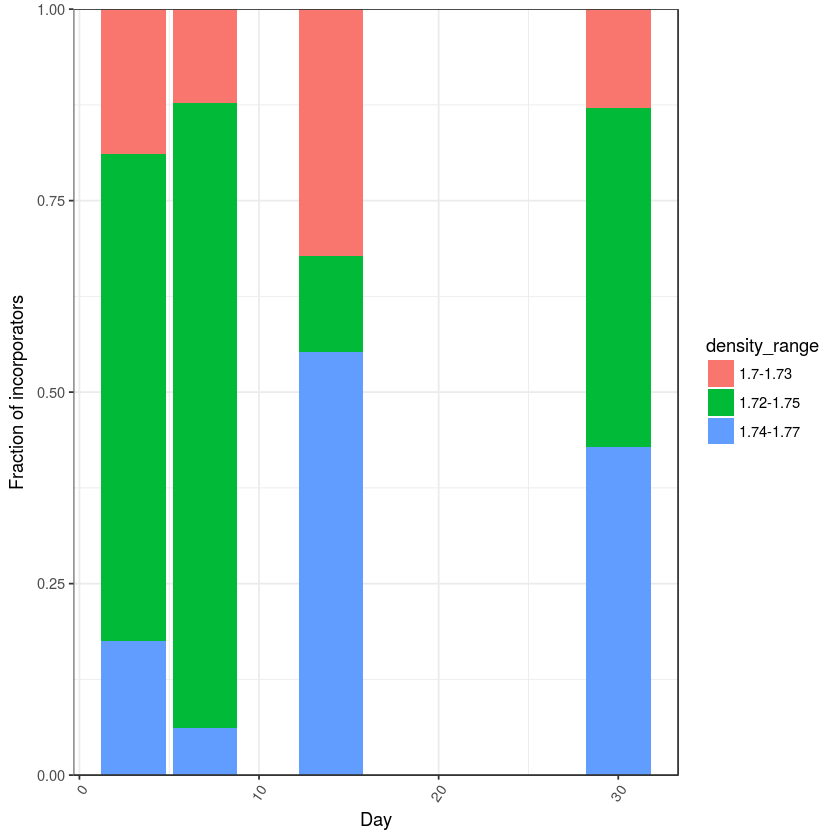

In [17]:
# summarizing
df_l2fc_s = df_l2fc2 %>% 
  filter(padj < padj_cutoff) %>%
  mutate(density_range = paste(density_min, density_max, sep='-')) %>% 
  group_by(Day, sparsity_threshold, density_range) %>%
  summarize(n_incorp_OTUs = OTU %>% unique %>% length) 

#plotting
ggplot(df_l2fc_s, aes(Day, n_incorp_OTUs, fill=density_range)) +
    geom_bar(stat='identity', position='fill') +
    labs(x='Day', y='Fraction of incorporators') +
    scale_y_continuous(expand=c(0,0)) +
    theme_bw() +
    theme(
      axis.text.x = element_text(angle=55, hjust=1)
    )

In [18]:
df_l2fc2 %>% 
  filter(padj < padj_cutoff) %>%
  mutate(density_range = paste(density_min, density_max, sep='-')) %>% 
  group_by(Day, sparsity_threshold, density_range) %>%
  summarize(n_incorp_OTUs = OTU %>% unique %>% length) %>% 
  ungroup() %>% 
  group_by(Day, sparsity_threshold) %>%
  mutate(total_OTUs = sum(n_incorp_OTUs)) %>%
  mutate(percent_OTUs = n_incorp_OTUs/total_OTUs*100)

Day,sparsity_threshold,density_range,n_incorp_OTUs,total_OTUs,percent_OTUs
3,0.45,1.7-1.73,14,74,18.918919
3,0.45,1.72-1.75,47,74,63.513514
3,0.45,1.74-1.77,13,74,17.567568
7,0.30,1.7-1.73,10,82,12.195122
7,0.30,1.72-1.75,67,82,81.707317
7,0.30,1.74-1.77,5,82,6.097561
14,0.20,1.7-1.73,31,96,32.291667
14,0.20,1.72-1.75,12,96,12.500000
14,0.20,1.74-1.77,53,96,55.208333
30,0.40,1.7-1.73,9,70,12.857143


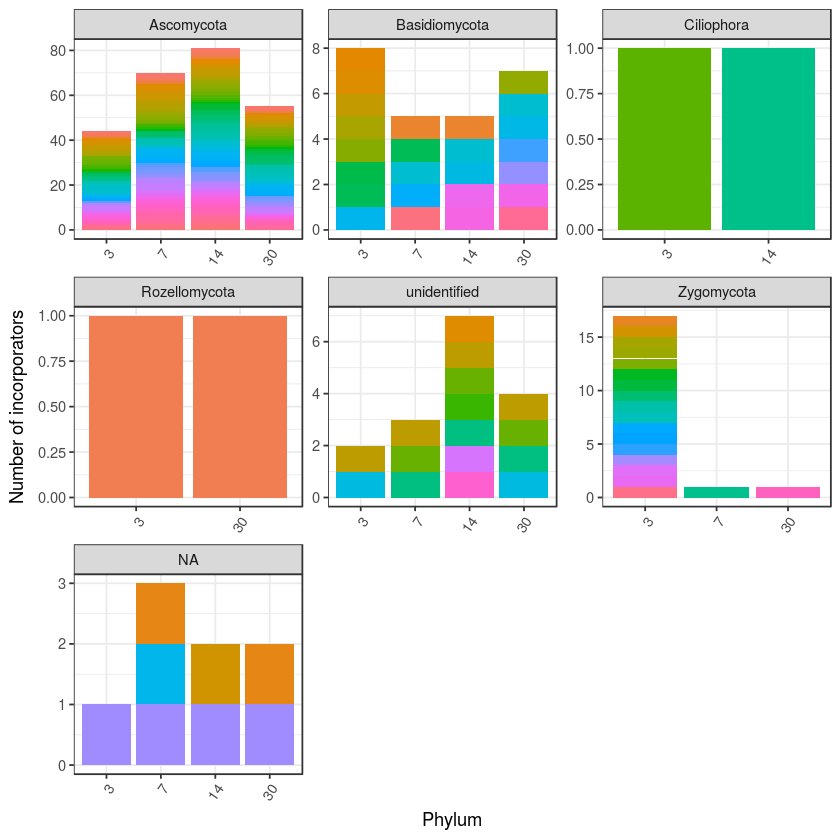

In [19]:
# summarizing
df_l2fc_s = df_l2fc2 %>% 
  filter(padj < padj_cutoff) %>%
  mutate(Rank2 = gsub('^p__', '', Rank2)) %>%
  group_by(Day, Rank2, OTU) %>%
  summarize(n_incorp_OTUs = OTU %>% unique %>% length) %>%
  ungroup()

# plotting
ggplot(df_l2fc_s, aes(as.factor(Day), n_incorp_OTUs, color)) +
    geom_bar(aes(fill = OTU), stat='identity') +
    labs(x='Phylum', y='Number of incorporators') +
    facet_wrap(~ Rank2, scales='free') +
    theme_bw() +
    theme(
      axis.text.x = element_text(angle=55, hjust=1)
    ) + guides(fill=FALSE)


In [20]:
# summarizing
df_l2fc_s = df_l2fc2 %>% 
  filter(padj < padj_cutoff) %>%
  mutate(Rank2 = gsub('^p__', '', Rank2)) %>%
  group_by(Day, Rank2) %>%
  summarize(n_incorp_OTUs = OTU %>% unique %>% length) %>% arrange(Rank2)

df_l2fc_s

Day,Rank2,n_incorp_OTUs
3,Ascomycota,44
7,Ascomycota,70
14,Ascomycota,81
30,Ascomycota,55
3,Basidiomycota,8
7,Basidiomycota,5
14,Basidiomycota,5
30,Basidiomycota,7
3,Ciliophora,1
14,Ciliophora,1


In [21]:
df_l2fc_s = df_l2fc2 %>% 
  filter(padj < 0.10 & Rank2 == 'p__Zygomycota') %>%
  mutate(Rank2 = gsub('^p__', '', Rank2))

df_l2fc_s

Day,OTU,log2FoldChange,p,padj,Rank1,Rank2,Rank3,Rank4,Rank5,Rank6,Rank7,density_min,density_max,sparsity_threshold,sparsity_apply,l2fc_threshold
7,OTU.27,2.293286,7.441098e-10,3.556332e-08,k__Fungi,Zygomycota,c__Incertae sedis,o__Mortierellales,f__Mortierellaceae,g__Mortierella,NA,1.74,1.77,0.30,all,0.25
30,OTU.712,3.425272,2.170516e-03,1.727517e-02,k__Fungi,Zygomycota,c__Incertae sedis,o__Mucorales,f__Mucoraceae,NA,NA,1.72,1.75,0.40,all,0.25
3,OTU.6,1.710307,9.960678e-05,1.778692e-03,k__Fungi,Zygomycota,c__Incertae sedis,o__Mortierellales,f__Mortierellaceae,g__Mortierella,NA,1.70,1.73,0.45,all,0.25
3,OTU.448,2.965047,2.014646e-04,2.905740e-03,k__Fungi,Zygomycota,c__Incertae sedis,o__Mortierellales,NA,NA,NA,1.70,1.73,0.45,all,0.25
3,OTU.14,2.487263,7.243253e-05,1.468227e-03,k__Fungi,Zygomycota,c__Incertae sedis,o__Mortierellales,NA,NA,NA,1.70,1.73,0.45,all,0.25
3,OTU.17165,2.771717,1.916508e-06,5.749523e-05,k__Fungi,Zygomycota,c__Incertae sedis,o__Mortierellales,NA,NA,NA,1.70,1.73,0.45,all,0.25
3,OTU.23,1.495500,3.415406e-04,4.131540e-03,k__Fungi,Zygomycota,c__Incertae sedis,o__Mortierellales,f__Mortierellaceae,g__Mortierella,NA,1.70,1.73,0.45,all,0.25
3,OTU.8815,1.956286,4.161091e-03,3.355719e-02,k__Fungi,Zygomycota,c__Incertae sedis,o__Mortierellales,f__Mortierellaceae,g__Mortierella,NA,1.70,1.73,0.45,all,0.25
3,OTU.22,2.222264,2.082054e-09,1.735045e-07,k__Fungi,Zygomycota,c__Incertae sedis,o__Mortierellales,f__Mortierellaceae,g__Mortierella,NA,1.72,1.75,0.45,all,0.25
3,OTU.439,2.923155,5.847694e-03,4.299775e-02,k__Fungi,Zygomycota,c__Incertae sedis,o__Mortierellales,f__Mortierellaceae,g__Mortierella,NA,1.72,1.75,0.45,all,0.25


In [22]:
df_l2fc_s = df_l2fc2 %>% 
  filter(padj < padj_cutoff) %>%
  mutate(Rank2 = gsub('^p__', '', Rank2)) %>%
  group_by(Day, Rank3, Rank2) %>%
  summarize(n_incorp_OTUs = OTU %>% unique %>% length)  %>% arrange(Rank2)

df_l2fc_s

Day,Rank3,Rank2,n_incorp_OTUs
3,c__Dothideomycetes,Ascomycota,2
3,c__Eurotiomycetes,Ascomycota,4
3,c__Incertae sedis,Ascomycota,5
3,c__Leotiomycetes,Ascomycota,2
3,c__Orbiliomycetes,Ascomycota,2
3,c__Saccharomycetes,Ascomycota,3
3,c__Sordariomycetes,Ascomycota,19
3,c__unidentified,Ascomycota,3
3,NA,Ascomycota,4
7,c__Eurotiomycetes,Ascomycota,3


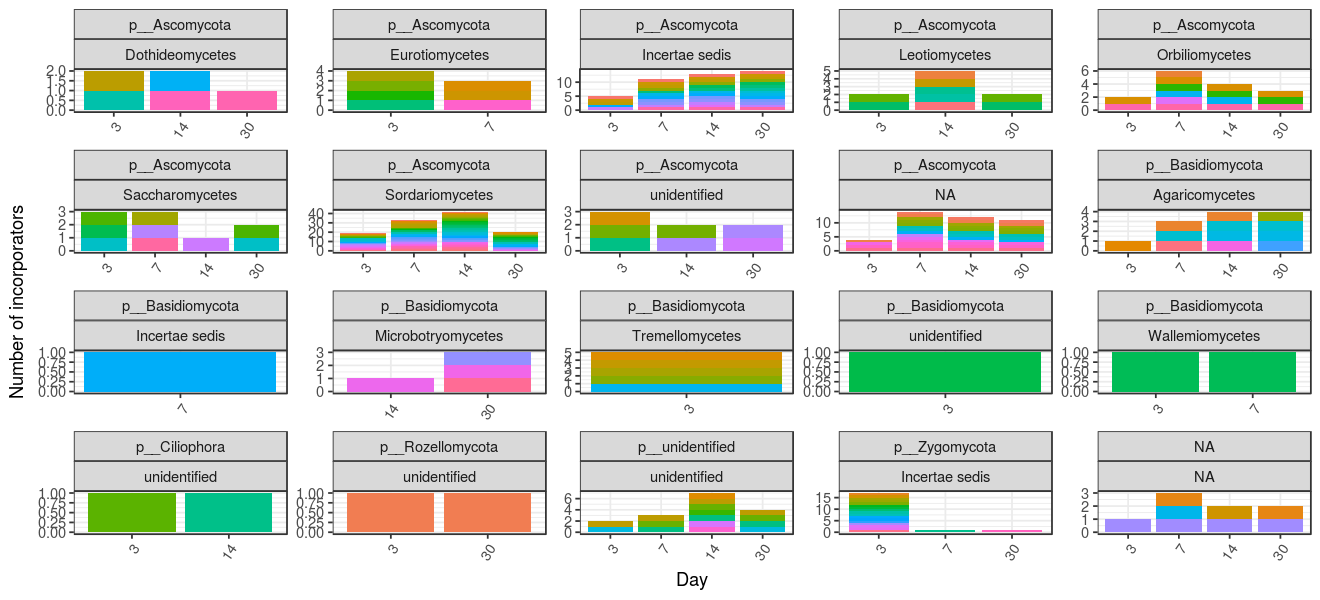

In [47]:
# summarizing
df_l2fc_s = df_l2fc2 %>% 
  filter(padj < padj_cutoff) %>%
  mutate(Rank3 = gsub('^c__', '', Rank3)) %>%
  group_by(Day, Rank3, Rank2, OTU) %>%
  summarize(n_incorp_OTUs = OTU %>% unique %>% length) %>%
  ungroup()

# plotting
ggplot(df_l2fc_s, aes(as.factor(Day), n_incorp_OTUs, color)) +
    geom_bar(aes(fill = OTU), stat='identity') +
    labs(x='Day', y='Number of incorporators') +
    facet_wrap(Rank2~ Rank3, scales='free') +
    theme_bw() +
    theme(
      axis.text.x = element_text(angle=55, hjust=1)
    ) + guides(fill=FALSE)






[1] 1.728221 7.554533

[1] 4.043595

[1] 1.365679

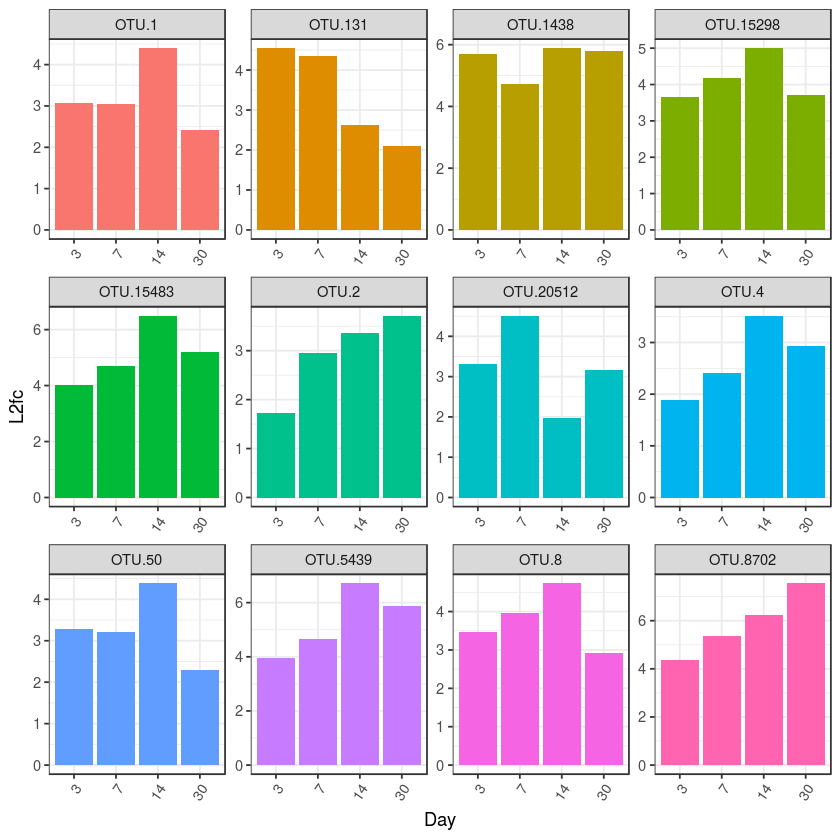

In [24]:
df_l2fc_s = df_l2fc2 %>% 
  filter(padj < padj_cutoff) %>%
  mutate(Rank3 = gsub('^c__', '', Rank3)) %>%
  group_by(OTU, Rank3, Rank5, Rank6, Rank7) %>%
  summarize(day_incorps = Day %>% unique %>% length) %>%
  filter(day_incorps ==4) %>%
  arrange(Rank3) %>%
  ungroup()


fourdays = filter(df_l2fc2, OTU %in% df_l2fc_s$OTU)
range(fourdays$log2FoldChange)
mean(fourdays$log2FoldChange)
sd(fourdays$log2FoldChange)


ggplot(fourdays, aes(as.factor(Day), log2FoldChange, color)) +
    geom_bar(aes(fill = OTU), stat='identity') +
    labs(x='Day', y='L2fc') +
    facet_wrap(~ OTU, scales='free') +
  #  geom_text(aes(label = (Rank3))) + 
    theme_bw() +
    theme(
      axis.text.x = element_text(angle=55, hjust=1)
    ) + guides(fill=FALSE)

In [25]:
filter(df_l2fc2, OTU %in% c('OTU.2', 'OTU.3', 'OTU.8') & padj<0.10) %>% arrange(OTU, Day) %>% select(OTU, Day, log2FoldChange)

OTU,Day,log2FoldChange
OTU.2,3,1.728221
OTU.2,7,2.958096
OTU.2,14,3.351991
OTU.2,30,3.714804
OTU.3,7,2.661521
OTU.3,14,2.316791
OTU.3,30,1.360808
OTU.8,3,3.456544
OTU.8,7,3.972509
OTU.8,14,4.736470


In [26]:
# summarizing
df_l2fc_s = df_l2fc2 %>% 
  filter(padj < padj_cutoff) %>%
  mutate(Rank3 = gsub('^c__', '', Rank3)) %>%
  group_by(OTU, Rank3) %>%
  summarize(n_incorp_OTUs = OTU %>% unique %>% length) %>%
  group_by(OTU, Rank3) %>%
  summarize(OTU_day = sum(n_incorp_OTUs)) %>%
  #filter(OTU_day > 1) %>%
  group_by(OTU_day, Rank3) %>%
  summarise(cat = OTU %>% unique %>% length) %>% arrange(-cat)

df_l2fc_s

OTU_day,Rank3,cat
1,Sordariomycetes,69
1,Incertae sedis,35
1,NA,21
1,unidentified,17
1,Agaricomycetes,9
1,Eurotiomycetes,7
1,Leotiomycetes,7
1,Saccharomycetes,7
1,Orbiliomycetes,6
1,Dothideomycetes,5


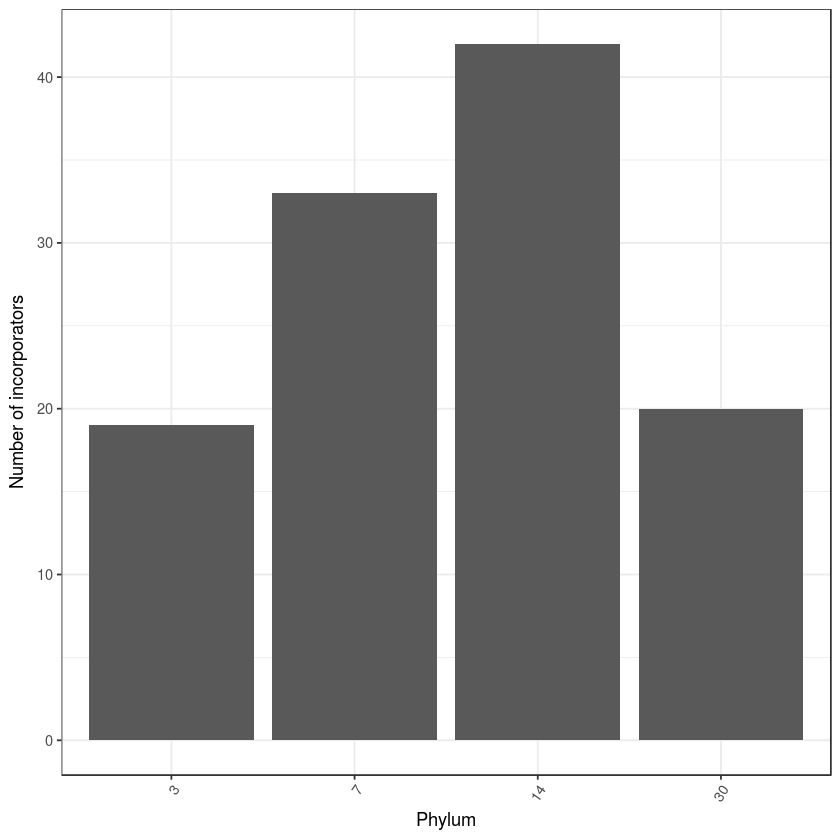

In [27]:
# summarizing
df_l2fc_s = df_l2fc2 %>%   
  mutate(Rank3 = gsub('^c__', '', Rank3)) %>%
  filter(padj < padj_cutoff & Rank3 == "Sordariomycetes") %>%
  group_by(Day, Rank3) %>%
  summarize(n_incorp_OTUs = OTU %>% unique %>% length) %>%
  ungroup()

# plotting
ggplot(df_l2fc_s, aes(as.factor(Day), n_incorp_OTUs)) +
    geom_bar(stat='identity') +
    labs(x='Phylum', y='Number of incorporators') +
    theme_bw() +
    theme(
      axis.text.x = element_text(angle=55, hjust=1)
    )

In [28]:
df_l2fc_s = df_l2fc2 %>% 
  filter(padj < padj_cutoff) %>%
  mutate(Rank3 = gsub('^c__', '', Rank3)) %>%
  group_by(Day, Rank3) %>%
  summarize(n_incorp_OTUs = OTU %>% unique %>% length) %>%
  arrange(Rank3)

df_l2fc_s

Day,Rank3,n_incorp_OTUs
3,Agaricomycetes,1
7,Agaricomycetes,3
14,Agaricomycetes,4
30,Agaricomycetes,4
3,Dothideomycetes,2
14,Dothideomycetes,2
30,Dothideomycetes,1
3,Eurotiomycetes,4
7,Eurotiomycetes,3
3,Incertae sedis,22


In [29]:
df_l2fc_s = df_l2fc2 %>% 
  filter(padj < padj_cutoff) %>%
  mutate(Rank3 = gsub('^c__', '', Rank3)) %>%
  mutate(Rank6 = gsub('^g__', '', Rank6)) %>%
  mutate(Rank7 = gsub('^s__', '', Rank7)) %>%
  group_by(Rank6, Rank7, Rank3) %>%
  summarize(n_incorp_OTUs = OTU %>% unique %>% length) %>%
  arrange(-n_incorp_OTUs)

df_l2fc_s

Rank6,Rank7,Rank3,n_incorp_OTUs
NA,NA,Sordariomycetes,24
NA,NA,NA,21
Staphylotrichum,Staphylotrichum coccosporum,Incertae sedis,15
Mortierella,NA,Incertae sedis,8
unidentified,Fungi sp,unidentified,7
unidentified,Sordariales sp,Sordariomycetes,6
Schizothecium,NA,Sordariomycetes,5
unidentified,Ascomycota sp,unidentified,5
NA,NA,Incertae sedis,5
Arthrobotrys,Arthrobotrys oligospora,Orbiliomycetes,4


In [30]:
df_l2fc_s = df_l2fc2 %>% 
  filter(padj < padj_cutoff) %>%
  mutate(Rank3 = gsub('^c__', '', Rank3)) %>%
  mutate(Rank6 = gsub('^g__', '', Rank6)) %>%
  filter(Rank3 == 'Sordariomycetes') %>% 
  group_by(Rank6) %>%
  summarize(n_incorp_OTUs = OTU %>% unique %>% length) %>%
  arrange(-n_incorp_OTUs)

df_l2fc_s#$Rank6

Rank6,n_incorp_OTUs
NA,24
unidentified,17
Schizothecium,5
Acremonium,3
Chaetomium,3
Monographella,2
Arthrinium,1
Cladorrhinum,1
Clonostachys,1
Fusarium,1


Warning message in brewer.pal(10, "Dark2"):
“n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
”

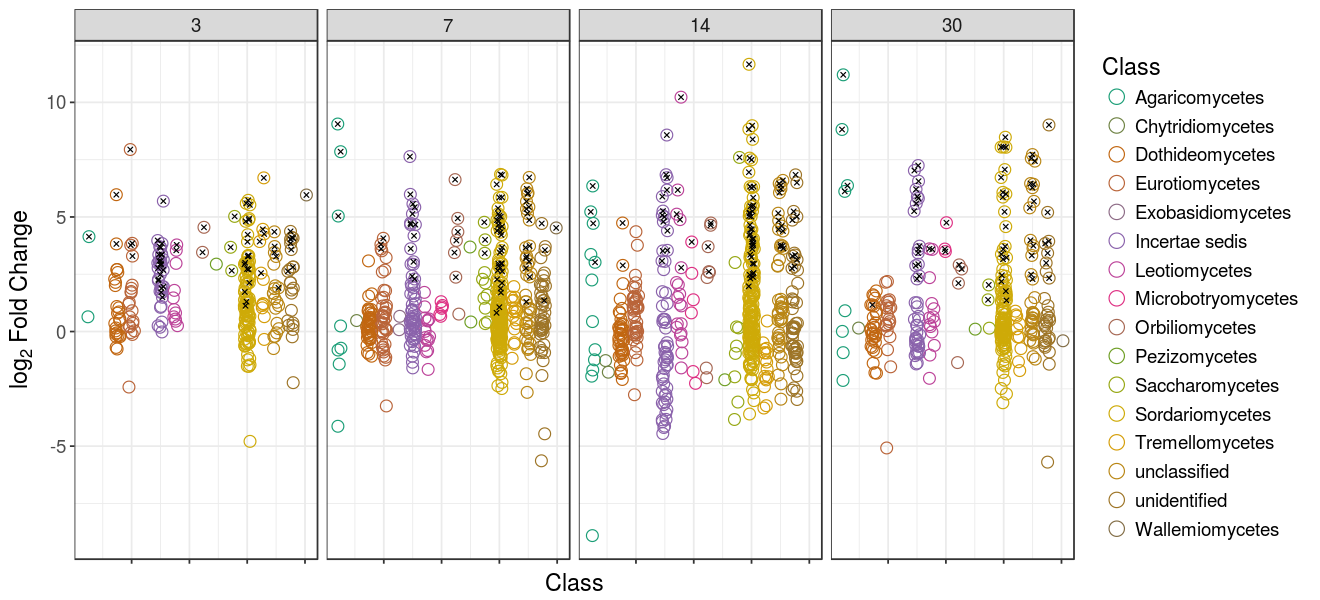

In [65]:
d = df_l2fc2 %>% mutate(Rank3 = gsub('^c__', '', Rank3)) 

FDR = 0.10
l2fc.threshold = 0.25

d$Rank3 = as.character(d$Rank3)
d$Rank3[is.na(d$Rank3)] = "unclassified"
d$Rank3 = factor(d$Rank3)

max.l2fc = ddply(d, .(Rank3), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank3, max.l2fc[order(-max.l2fc$M),]$Rank3)

M = max(as.numeric(d$Rank3), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank3)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank3)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank3))
p = p + facet_wrap(~Day, nrow=1, ncol=4)

p = p + geom_point(alpha = 1.00, shape = 21, size = 3)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj <= FDR), color = "black", shape = 4, size = 1)

#p = p + geom_hline(yintercept = sd(d$log2FoldChange))
#p = p + geom_hline(yintercept = 2*sd(d$log2FoldChange), color = 'black')

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Class", color = "Class")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p = p + theme(text = element_text(size=14)) 

p

In [69]:
ggsave(filename = "data/figs/l2fc_byclass_MW.pdf", plot = p, width = 10, height = 5)

Warning message in brewer.pal(10, "Dark2"):
“n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
”

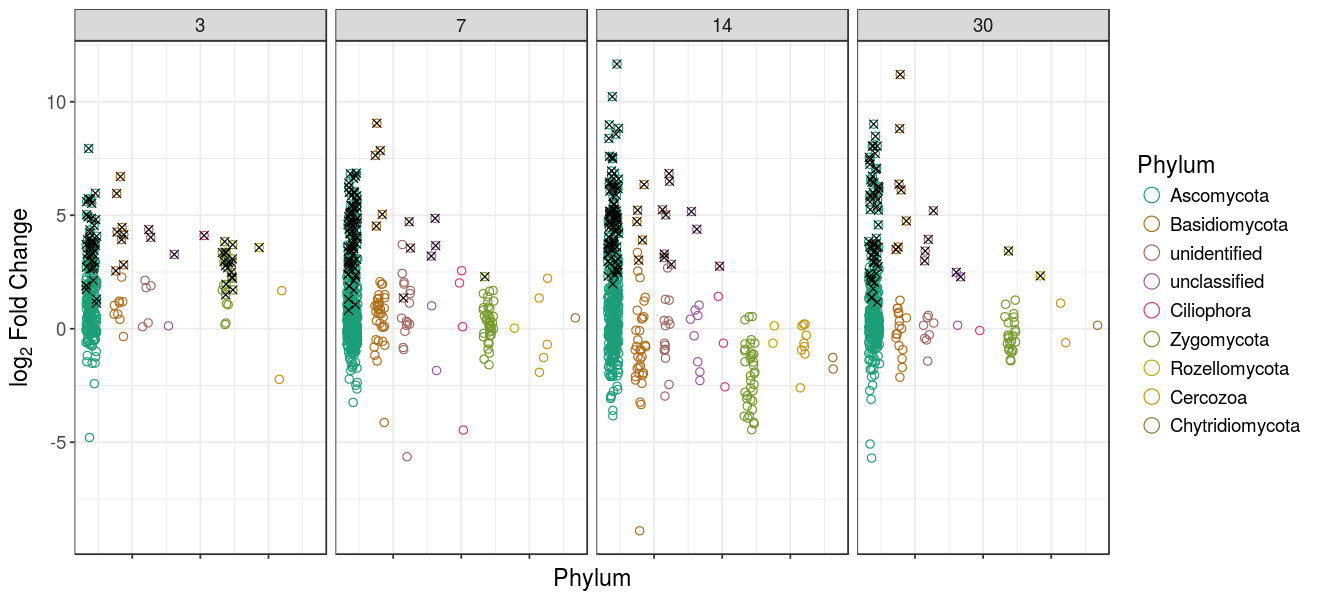

In [33]:

options(repr.plot.width = 11, repr.plot.height = 5)



d = df_l2fc2 %>% mutate(Rank2 = gsub('^p__', '', Rank2)) 

FDR = 0.10
#l2fc.threshold = 2.3

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)



M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p2 = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))
p2 = p2 + facet_wrap(~as.numeric(Day), nrow=1, ncol=4)

p2 = p2 + geom_point(alpha = 1.00, shape = 21, size = 2)

p2 = p2 + scale_color_manual(values = getPalette(colourCount))

p2 = p2 + geom_point(data = subset(d, padj <= FDR), color = "black", shape = 4, size = 2)

#p2 = p2 + geom_hline(yintercept = 2.3)

p2 = p2 + theme_bw()

p2 = p2 + theme(axis.text.x = element_blank())

p2 = p2 + labs(x = "Phylum", color = "Phylum")

p2 = p2 + guides(col = guide_legend(ncol = 2))

p2 = p2 + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p2 = p2 + guides(colour = guide_legend(override.aes = list(size=4)))

p2 = p2 + theme(text = element_text(size=14)) 


p2

In [34]:
ggsave(filename = "data/figs/l2fc_byphyla_MW.pdf", plot = p, width = 12, height = 7)

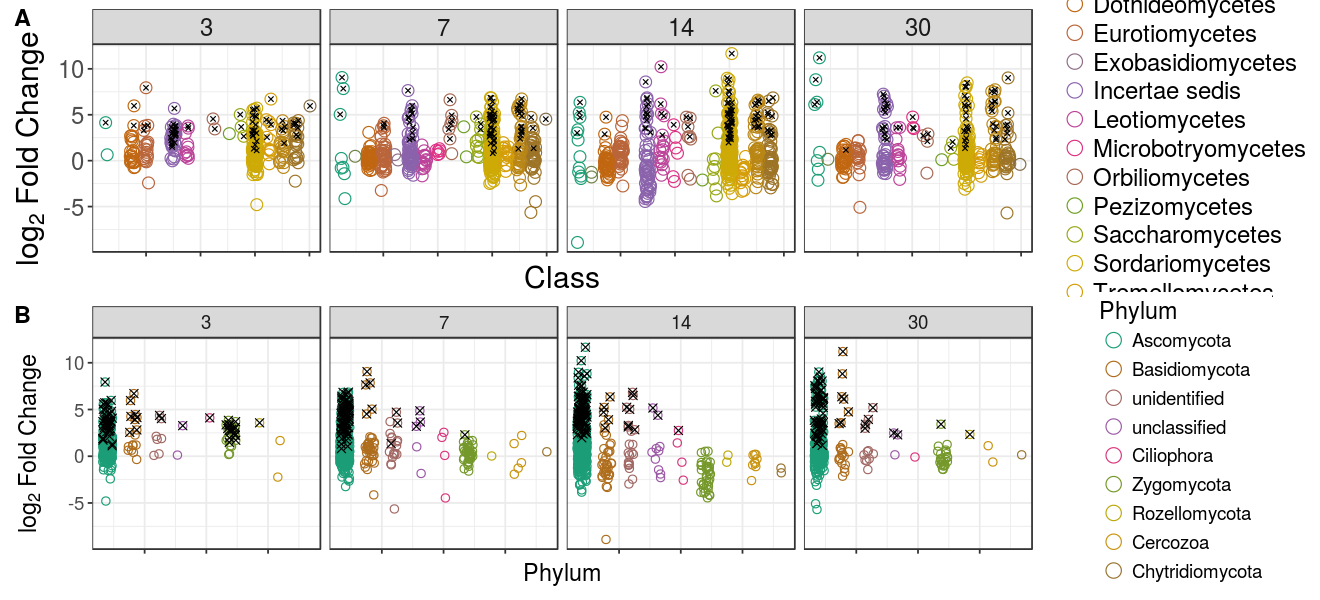

In [35]:
p.l2fc = plot_grid(p, p2, labels = c("A", "B"), nrow = 2, align = "v")

p.l2fc

In [36]:
save_plot("data/figs/l2fc_combo.pdf", p.l2fc,
          ncol = 2, # we're saving a grid plot of 2 columns
          # each individual subplot should have an aspect ratio of 1.3
          base_aspect_ratio = 2
          )


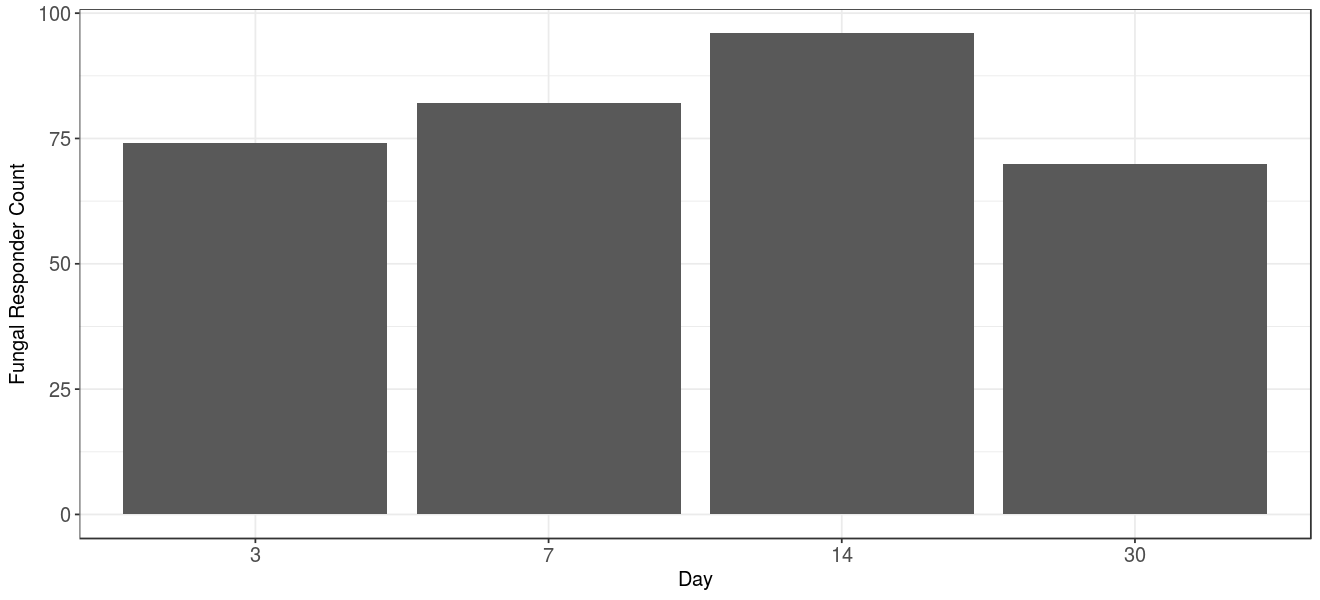

In [59]:
d = df_l2fc2 %>%
          group_by(Day) %>%
          summarize(responders = sum(padj <= 0.10))

px = ggplot(d, aes(x = as.factor(Day), y = responders))

px = px + geom_bar(stat = "identity", position = "dodge")

px = px + xlab("Day") + ylab("Fungal Responder Count")

px = px + scale_fill_discrete(name = "Day")

px = px + theme_bw()
px = px + theme(axis.text = element_text(size = 12),
              axis.title = element_text(size = 12), 
              legend.text = element_text(size = 12), 
              legend.title = element_text(size = 12))


px

In [49]:

l2fc.df = tbl_df(read.table("/home/ashley/succ-C-DNASIP/data/l2fc_table.csv",
           sep = ",",
           header = TRUE))
l2fc.df = filter(l2fc.df, Treatment == "13CCPS")

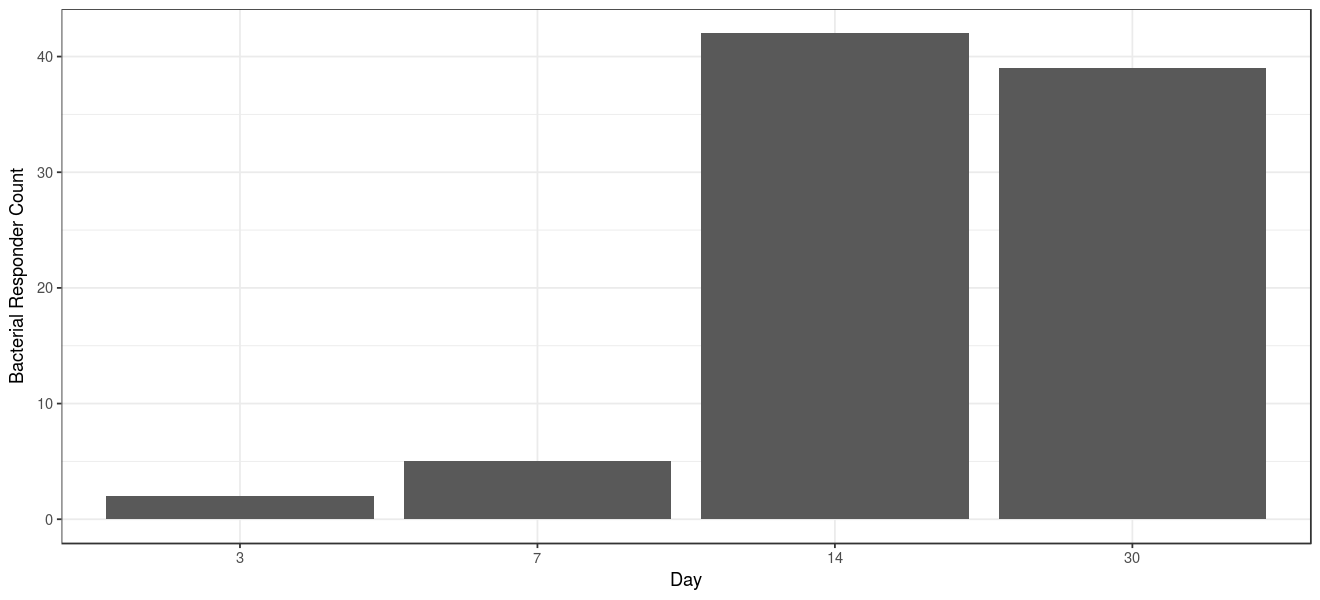

In [55]:
d = l2fc.df %>%
          group_by(Day) %>%
          summarize(responders = sum(padj <= 0.10))

px2 = ggplot(d, aes(x = factor(Day), y = responders))

px2 = px2 + geom_bar(stat = "identity", position = "dodge")

px2 = px2 + theme_bw()
p = p + theme(axis.text = element_text(size = 12),
              axis.title = element_text(size = 12), 
              legend.text = element_text(size = 12), 
              legend.title = element_text(size = 12))

px2 = px2 + xlab("Day") + ylab("Bacterial Responder Count")

px2 = px2 + scale_fill_discrete(name = "Day")


px2

In [51]:
library(tidyr); library(magrittr)

In [52]:
data = data.frame(Day = c(0, 3, 7, 14, 30),
                  cellulose = c(100, 88.7, 78.8, 62.4, 39.8)) %>%
    gather(Substrate, "Cellulose Remaining (%)", -Day) %>%
    na.omit
    
data

Day,Substrate,Cellulose Remaining (%)
0,cellulose,100.0
3,cellulose,88.7
7,cellulose,78.8
14,cellulose,62.4
30,cellulose,39.8


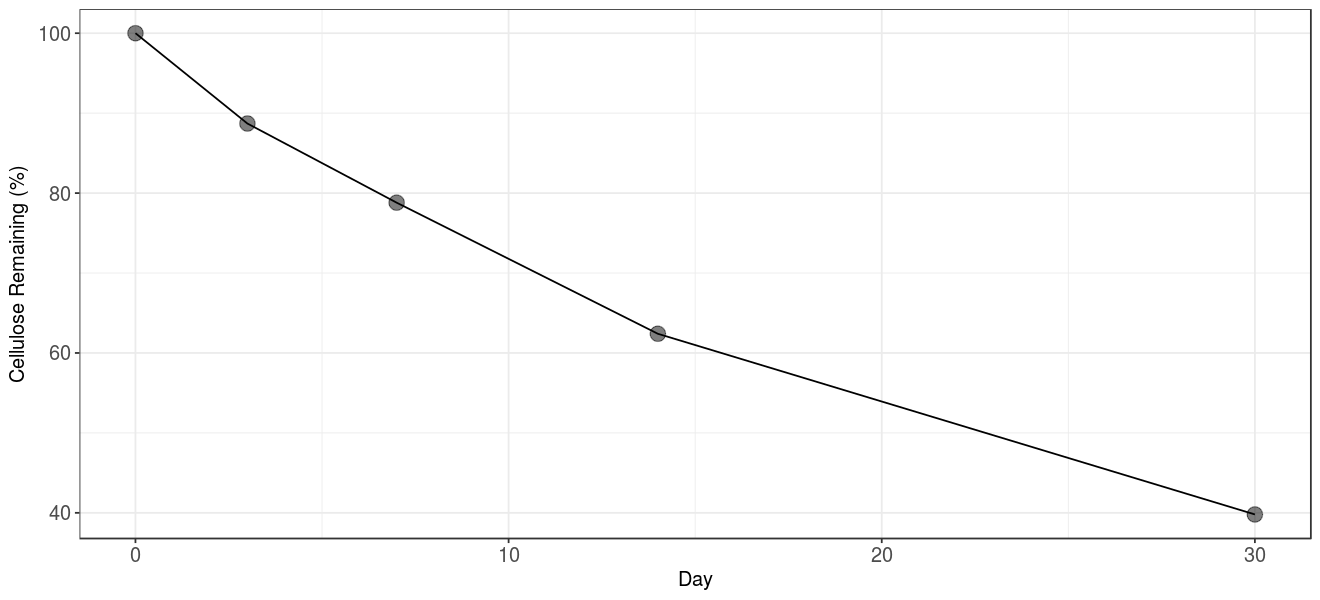

In [60]:
p = ggplot(data, aes(x = Day, y = `Cellulose Remaining (%)`))

p = p + geom_point(size = 4, alpha = 0.5)
p = p + geom_line()
p = p + labs(x = "Day")
p = p + scale_color_manual(values = c("#4daf4a", "#377eb8"))
p = p + theme_bw()
p = p + theme(axis.text = element_text(size = 12),
              axis.title = element_text(size = 12), 
              legend.text = element_text(size = 12), 
              legend.title = element_text(size = 12))
p = p + guides(color = FALSE)

p

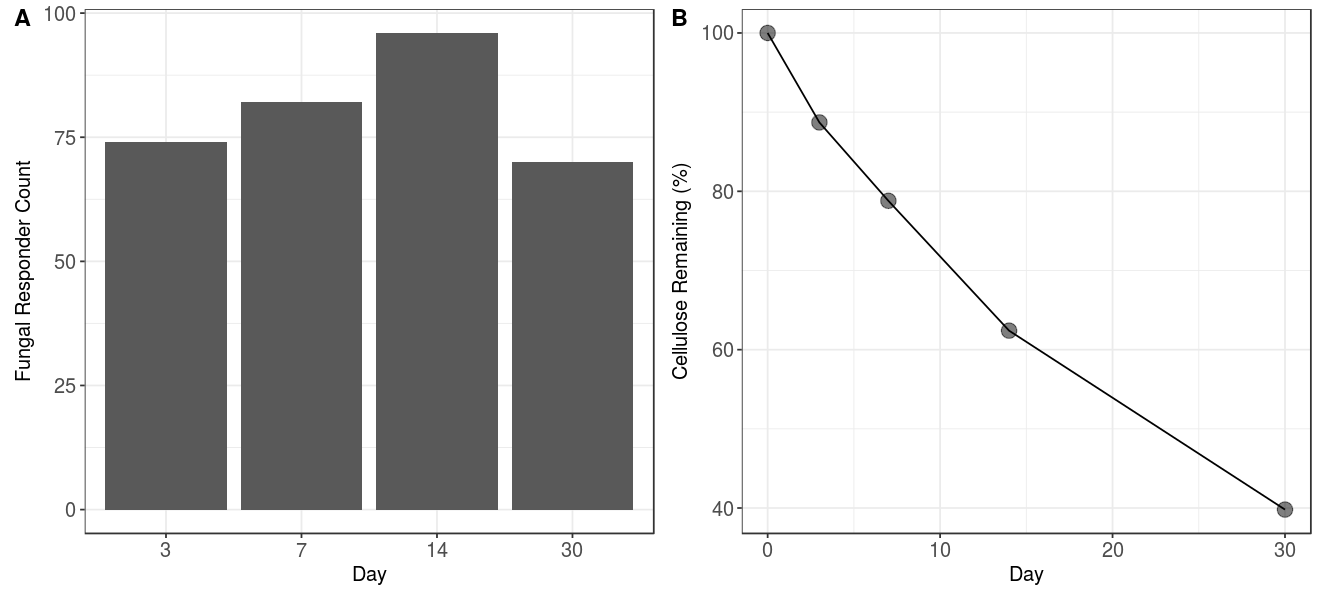

In [61]:
p2 = plot_grid(px, p, labels = c("A", "B"), nrow = 1)

p2

In [62]:
ggsave(filename = "data/figs/responders_by_day_plusCellulose.pdf", plot = p2, width = 7, height = 3.5, units = "in")

In [45]:
sessionInfo()


R version 3.3.2 (2016-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.2 LTS

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] magrittr_1.5       cowplot_0.7.0      RColorBrewer_1.1-2 tidyr_0.6.1       
 [5] stringr_1.2.0      data.table_1.10.4  phyloseq_1.19.1    HTSSIP_1.0.3      
 [9] ggplot2_2.2.1      dplyr_0.5.0        plyr_1.8.4        

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.2-5        repr_0.12.0         reshape2_1.4.2     
 [4] splines_3.3.2       lattice_0.20-35     rhdf5_2.18.0       
 [7] colorsp